In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU

In [ ]:
!pip install yfinance

import yfinance as yf

In [ ]:
!pip install keras-tuner

from kerastuner.tuners import RandomSearch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 20.7 MB/s eta 0:00:00
Using TensorFlow backend


<ipython-input-5-77500691c99c>:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
ms = yf.download('GOOG',
            start="2013-01-01",
            end="2023-09-30",
            progress=False)
df = ms[["Adj Close", "Open", "Close", "High", "Low"]].round(3)
df.head(10)

,Adj Close,Open,Close,High,Low
Date,,,,,
2013-01-02,18.014,17.918,18.014,18.107,17.847
2013-01-03,18.024,18.056,18.024,18.230,17.951
2013-01-04,18.380,18.165,18.380,18.468,18.124
2013-01-07,18.300,18.318,18.300,18.415,18.196
2013-01-08,18.264,18.320,18.264,18.339,18.043
2013-01-09,18.384,18.238,18.384,18.390,18.147
2013-01-10,18.468,18.501,18.468,18.555,18.269
2013-01-11,18.431,18.481,18.431,18.491,18.339
2013-01-14,18.014,18.356,18.014,18.486,17.991


In [ ]:
def ts_data(df, X_steps, y_steps):
  train_df = df[:"2021"].Close.values.reshape(-1, 1)
  test_df = df["2022":].Close.values.reshape(-1, 1)

  sc = MinMaxScaler(feature_range=(0, 1))
  train_df_scaled = sc.fit_transform(train_df)

  X_train = []
  y_train = []
  for i in range(X_steps, len(train_df_scaled)-y_steps+1):
    X_train.append(train_df_scaled[i-X_steps:i, 0])
    y_train.append(train_df_scaled[i:i+y_steps, 0])
  X_train = np.array(X_train)
  y_train = np.array(y_train)

  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

  X = df.Close.values
  X = X[len(X)-len(test_df)-X_steps:]
  X = X.reshape(-1, 1)
  X = sc.transform(X)

  X_test = []
  y_test = []
  for i in range(X_steps, len(test_df)+X_steps-y_steps+1):
    X_test.append(X[i-X_steps:i, 0])
    y_test.append(X[i:i+y_steps, 0])

  X_test = np.array(X_test)
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
  y_test = np.array(y_test)

  return X_train, y_train, X_test, y_test, sc

In [ ]:
X_train, y_train, X_test, y_test, sc = ts_data(df, 5, 2)

TimeSteps: X_train: 5, X_test: 2

In [ ]:
def prediction_plot(predictions):
  fig, ax = plt.subplots()
  ax.plot(df["2021":].index[:len(y_test)],
          sc.inverse_transform(y_test[:, 0].reshape(-1, 1)), label="Real")
  ax.plot(df["2021":].index[:len(y_test)],
          sc.inverse_transform(predictions[:, 0].reshape(-1, 1)), label="Prediction")
  plt.legend()

#SimpleRNN

In [ ]:
def build_model(hp):
    model = Sequential()

    #number of layers
    num_layers = hp.Int('num_layers', min_value=1, max_value=5, step=1)
    # Add layers
    for _ in range(num_layers):
        model.add(SimpleRNN(units=hp.Int('units', min_value=32, max_value=128, step=32),
                            return_sequences=True))
    # Add the final layer
    model.add(SimpleRNN(units=hp.Int('units', min_value=32, max_value=128, step=32)))
    model.add(Dense(2))

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])
    return model

# Define the Keras Tuner search space
simple_rnn_tuner = RandomSearch(
    build_model,
    objective='val_loss',
    project_name='simple_rnn_hyperparameters'
)

# Start the hyperparameter search
simple_rnn_tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

# Retrieve the best hyperparameters and build the final model
best_simple_rnn_hps = simple_rnn_tuner.get_best_hyperparameters(num_trials=1)[0]
simple_rnn_model = simple_rnn_tuner.hypermodel.build(best_simple_rnn_hps)

Trial 10 Complete [00h 00m 15s]
val_loss: 0.009957805275917053

Best val_loss So Far: 0.0022899070754647255
Total elapsed time: 00h 02m 22s


In [ ]:
simple_rnn_model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
simple_rnn_history = simple_rnn_model.fit(X_train, y_train, epochs=100, validation_split=0.20)

Epoch 1/100
57/57 [==============================] - 3s 10ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 2/100
57/57 [==============================] - 0s 7ms/step - loss: 8.5228e-05 - val_loss: 0.0012
Epoch 3/100
57/57 [==============================] - 0s 7ms/step - loss: 6.4771e-05 - val_loss: 0.0012
Epoch 4/100
57/57 [==============================] - 0s 7ms/step - loss: 6.2131e-05 - val_loss: 0.0011
Epoch 5/100
57/57 [==============================] - 0s 7ms/step - loss: 5.9326e-05 - val_loss: 6.0330e-04
Epoch 6/100
57/57 [==============================] - 1s 9ms/step - loss: 6.2099e-05 - val_loss: 0.0011
Epoch 7/100
57/57 [==============================] - 1s 10ms/step - loss: 5.6802e-05 - val_loss: 0.0012
Epoch 8/100
57/57 [==============================] - 1s 10ms/step - loss: 8.4233e-05 - val_loss: 3.3480e-04
Epoch 9/100
57/57 [==============================] - 1s 10ms/step - loss: 5.5705e-05 - val_loss: 7.4337e-04
Epoch 10/100
57/57 [==============================] - 1s 10ms

In [ ]:
simple_rnn_pred = simple_rnn_model.predict(X_test)

14/14 [==============================] - 0s 2ms/step


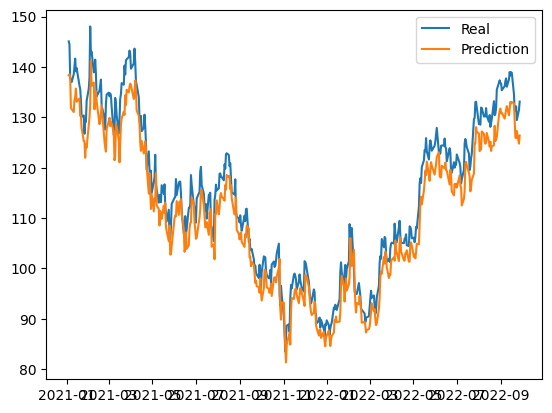

In [ ]:
prediction_plot(simple_rnn_pred)

#LSTM

In [ ]:
def build_model_LSTM(hp):
    model = Sequential()

    #number of layers
    num_layers = hp.Int('num_layers', min_value=1, max_value=5, step=1)
    # Add layers
    for _ in range(num_layers):
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                            return_sequences=True))
    # Add the final layer
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32)))
    model.add(Dense(2))

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])
    return model

# Define the Keras Tuner search space
LSTM_tuner = RandomSearch(
    build_model_LSTM,
    objective='val_loss',
    project_name='LSTM_hyperparameters'
)

# Start the hyperparameter search
LSTM_tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

# Retrieve the best hyperparameters and build the final model
best_LSTM_hps = LSTM_tuner.get_best_hyperparameters(num_trials=1)[0]
LSTM_model = LSTM_tuner.hypermodel.build(best_LSTM_hps)

Trial 10 Complete [00h 00m 27s]
val_loss: 0.0004832620616070926

Best val_loss So Far: 0.000414163718232885
Total elapsed time: 00h 04m 58s


In [ ]:
LSTM_model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
LSTM_history = LSTM_model.fit(X_train, y_train, epochs=100, validation_split=0.20)

Epoch 1/100


Exception ignored in: <function _xla_gc_callback at 0x7d07645ebeb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


57/57 [==============================] - 49s 31ms/step - loss: 1.5407e-04 - val_loss: 0.0015
Epoch 2/100
57/57 [==============================] - 1s 22ms/step - loss: 9.7543e-05 - val_loss: 0.0015
Epoch 3/100
57/57 [==============================] - 1s 21ms/step - loss: 8.8106e-05 - val_loss: 0.0011
Epoch 4/100
57/57 [==============================] - 1s 17ms/step - loss: 9.1575e-05 - val_loss: 0.0026
Epoch 5/100
57/57 [==============================] - 1s 13ms/step - loss: 9.6820e-05 - val_loss: 7.8339e-04
Epoch 6/100
57/57 [==============================] - 1s 14ms/step - loss: 8.8975e-05 - val_loss: 0.0028
Epoch 7/100
57/57 [==============================] - 1s 13ms/step - loss: 8.7125e-05 - val_loss: 9.9752e-04
Epoch 8/100
57/57 [==============================] - 1s 25ms/step - loss: 9.0408e-05 - val_loss: 0.0022
Epoch 9/100
57/57 [==============================] - 1s 13ms/step - loss: 9.3929e-05 - val_loss: 0.0026
Epoch 10/100
57/57 [==============================] - 1s 14ms/step 

In [ ]:
LSTM_pred = LSTM_model.predict(X_test)

14/14 [==============================] - 2s 6ms/step


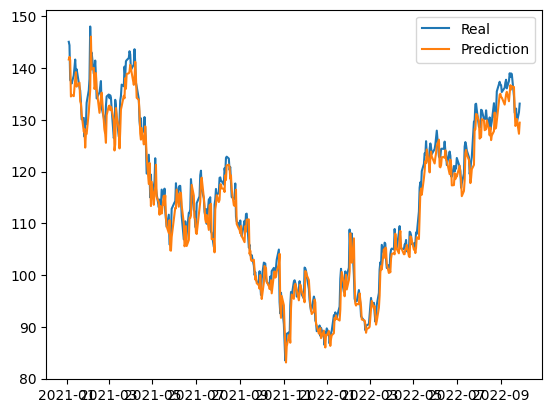

In [ ]:
prediction_plot(LSTM_pred)

#GRU

In [ ]:
def build_model_GRU(hp):
    model = Sequential()

    #number of layers
    num_layers = hp.Int('num_layers', min_value=1, max_value=5, step=1)
    # Add layers
    for _ in range(num_layers):
        model.add(GRU(units=hp.Int('units', min_value=32, max_value=128, step=32),
                            return_sequences=True))
    # Add the final layer
    model.add(GRU(units=hp.Int('units', min_value=32, max_value=128, step=32)))
    model.add(Dense(2))

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])
    return model

# Define the Keras Tuner search space
GRU_tuner = RandomSearch(
    build_model_GRU,
    objective='val_loss',
    project_name='GRU_hyperparameters'
)

# Start the hyperparameter search
GRU_tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

# Retrieve the best hyperparameters and build the final model
best_GRU_hps = GRU_tuner.get_best_hyperparameters(num_trials=1)[0]
GRU_model = GRU_tuner.hypermodel.build(best_GRU_hps)

Trial 10 Complete [00h 00m 20s]
val_loss: 0.0009383372962474823

Best val_loss So Far: 0.00030897679971531034
Total elapsed time: 00h 05m 06s


In [ ]:
GRU_model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
GRU_history = GRU_model.fit(X_train, y_train, epochs=100, validation_split=0.20)

Epoch 1/100
57/57 [==============================] - 7s 39ms/step - loss: 0.0029 - val_loss: 3.6864e-04
Epoch 2/100
57/57 [==============================] - 1s 17ms/step - loss: 6.9167e-05 - val_loss: 3.9805e-04
Epoch 3/100
57/57 [==============================] - 1s 25ms/step - loss: 6.4031e-05 - val_loss: 3.4442e-04
Epoch 4/100
57/57 [==============================] - 2s 34ms/step - loss: 6.3056e-05 - val_loss: 5.3937e-04
Epoch 5/100
57/57 [==============================] - 1s 23ms/step - loss: 6.5057e-05 - val_loss: 4.0564e-04
Epoch 6/100
57/57 [==============================] - 2s 27ms/step - loss: 6.5361e-05 - val_loss: 6.6240e-04
Epoch 7/100
57/57 [==============================] - 2s 26ms/step - loss: 6.7175e-05 - val_loss: 5.8027e-04
Epoch 8/100
57/57 [==============================] - 1s 16ms/step - loss: 6.4560e-05 - val_loss: 3.3709e-04
Epoch 9/100
57/57 [==============================] - 1s 15ms/step - loss: 6.4332e-05 - val_loss: 5.4552e-04
Epoch 10/100
57/57 [============

In [ ]:
GRU_pred = GRU_model.predict(X_test)

14/14 [==============================] - 1s 4ms/step


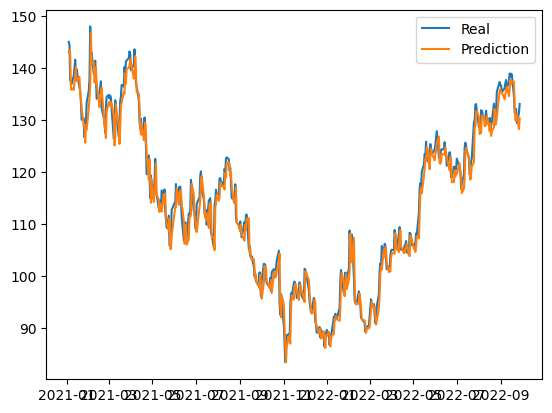

In [ ]:
prediction_plot(GRU_pred)

#Hybrid

In [ ]:
def build_model(hp):
    model = Sequential()

    # Number of layers
    num_layers = hp.Int('num_layers', min_value=2, max_value=5, step=1)

    # Choose between GRU and LSTM
    rnn_layer = hp.Choice('rnn_layer', values=['GRU', 'LSTM'])

    # Add layers
    for _ in range(num_layers):
        if rnn_layer == 'GRU':
            model.add(GRU(units=hp.Int('units', min_value=32, max_value=128, step=32),
                          return_sequences=True))
        else:  # Use LSTM
            model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                           return_sequences=True))

    # Add the final layer
    if rnn_layer == 'GRU':
        model.add(GRU(units=hp.Int('units', min_value=32, max_value=128, step=32)))
    else:  # Use LSTM
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32)))

    model.add(Dense(2))

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])
    return model

# Define the Keras Tuner search space
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    project_name='hybrid_rnn_hyperparameters'
)

# Start the hyperparameter search
tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

# Retrieve the best hyperparameters and build the final model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
hybrid_model = tuner.hypermodel.build(best_hps)

Trial 10 Complete [00h 00m 52s]
val_loss: 0.004930032882839441

Best val_loss So Far: 0.0003944663912989199
Total elapsed time: 00h 06m 53s


In [ ]:
hybrid_model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
hybrid_history = hybrid_model.fit(X_train, y_train, epochs=100, validation_split=0.20)

Epoch 1/100
57/57 [==============================] - 10s 35ms/step - loss: 0.0046 - val_loss: 0.0015
Epoch 2/100
57/57 [==============================] - 1s 16ms/step - loss: 8.8779e-05 - val_loss: 6.7297e-04
Epoch 3/100
57/57 [==============================] - 1s 15ms/step - loss: 9.1443e-05 - val_loss: 6.3234e-04
Epoch 4/100
57/57 [==============================] - 1s 23ms/step - loss: 8.0133e-05 - val_loss: 5.9314e-04
Epoch 5/100
57/57 [==============================] - 1s 25ms/step - loss: 8.0990e-05 - val_loss: 9.2616e-04
Epoch 6/100
57/57 [==============================] - 1s 21ms/step - loss: 7.9301e-05 - val_loss: 4.8647e-04
Epoch 7/100
57/57 [==============================] - 1s 15ms/step - loss: 8.4021e-05 - val_loss: 8.6919e-04
Epoch 8/100
57/57 [==============================] - 1s 16ms/step - loss: 8.9555e-05 - val_loss: 6.3744e-04
Epoch 9/100
57/57 [==============================] - 1s 15ms/step - loss: 8.3362e-05 - val_loss: 7.0822e-04
Epoch 10/100
57/57 [===============

In [ ]:
hybrid_pred = hybrid_model.predict(X_test)

14/14 [==============================] - 1s 4ms/step


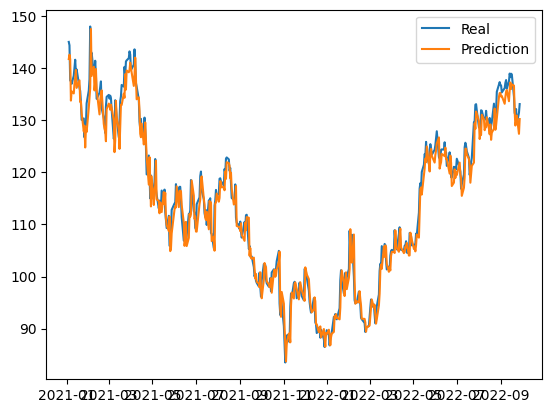

In [ ]:
prediction_plot(hybrid_pred)

#Validation Loss Graph

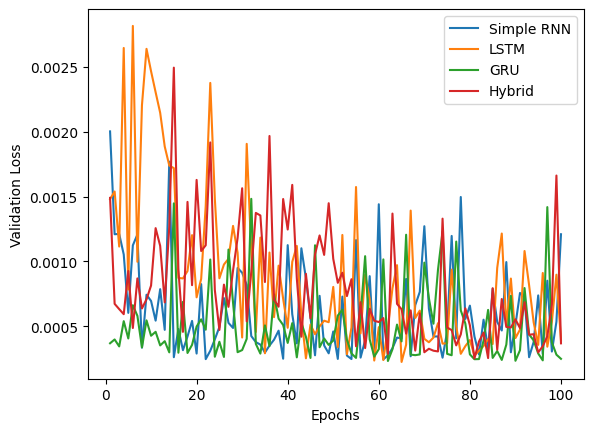

In [ ]:
val_loss_simple_rnn = simple_rnn_history.history['val_loss']
val_loss_LSTM = LSTM_history.history['val_loss']
val_loss_GRU = GRU_history.history['val_loss']
val_loss_hybrid = hybrid_history.history['val_loss']

epochs = range(1, 101)

plt.plot(epochs, val_loss_simple_rnn, label='Simple RNN')
plt.plot(epochs, val_loss_LSTM, label='LSTM')
plt.plot(epochs, val_loss_GRU, label='GRU')
plt.plot(epochs, val_loss_hybrid, label='Hybrid')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

#Train Data Prediction Graph

71/71 [==============================] - 0s 4ms/step


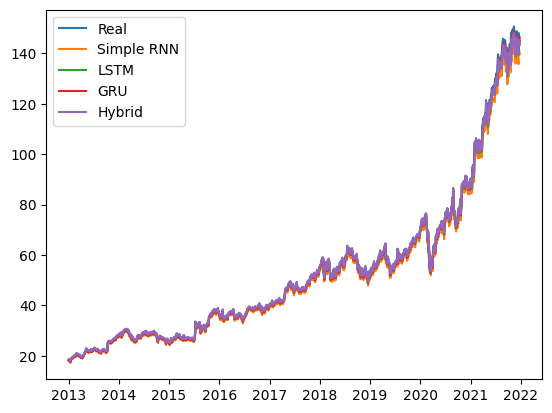

In [ ]:
simple_rnn_predict = simple_rnn_model.predict(X_train)
LSTM_predict = LSTM_model.predict(X_train)
GRU_predict = GRU_model.predict(X_train)
hybrid_predict = hybrid_model.predict(X_train)


fig, ax = plt.subplots()
ax.plot(df[:"2021"].index[:len(y_train)],
        sc.inverse_transform(y_train[:, 0].reshape(-1, 1)), label="Real")
ax.plot(df[:"2021"].index[:len(y_train)],
        sc.inverse_transform(simple_rnn_predict[:, 0].reshape(-1, 1)), label="Simple RNN")
ax.plot(df[:"2021"].index[:len(y_train)],
        sc.inverse_transform(LSTM_predict[:, 0].reshape(-1, 1)), label="LSTM")
ax.plot(df[:"2021"].index[:len(y_train)],
        sc.inverse_transform(GRU_predict[:, 0].reshape(-1, 1)), label="GRU")
ax.plot(df[:"2021"].index[:len(y_train)],
        sc.inverse_transform(hybrid_predict[:, 0].reshape(-1, 1)), label="Hybrid")
plt.legend()